# Reference:
#### https://github.com/PerpetualSmile/Sentiment-Analylsis-based-on-Attention-Mechanism/blob/master/Train%20Models.ipynb

## **IMPORTANT**: Create folders and upload files based on the following structure:

*   Transformer.py
*   utils.py
*   dataset
  *   IMDB
      *   X_train.h5 
      *   y_train.h5
      *   X_val.h5
      *   y_val.h5
      *   X_test.h5
      *   y_test.h5
      *   word2num_series.h5
      *   test.csv
  *   Yelp
      *   X_train.h5
      *   y_train.h5
      *   X_val.h5
      *   y_val.h5
      *   X_test.h5
      *   y_test.h5
      *   word2num_series.h5
      *   yelp_test.csv
*   word2vector
  *   glove.twitter.27B.200d.txt
*   output
  *   model_save
      *   Transformer_on_IMDB_l1_h1.pth
      *   Transformer_on_IMDB_l1_h2.pth
      *   Transformer_on_IMDB_l1_h4.pth
      *   Transformer_on_IMDB_l1_h8.pth
      *   Transformer_on_IMDB_l2_h1.pth
      *   Transformer_on_IMDB_l2_h2.pth
      *   Transformer_on_IMDB_l2_h4.pth
      *   Transformer_on_IMDB_l2_h8.pth
      *   Transformer_on_IMDB_l3_h1.pth
      *   Transformer_on_IMDB_l3_h2.pth
      *   Transformer_on_IMDB_l3_h4.pth
      *   Transformer_on_IMDB_l3_h8.pth
      *   Transformer_on_Yelp_l1_h1.pth
      *   Transformer_on_Yelp_l1_h2.pth
      *   Transformer_on_Yelp_l1_h4.pth
      *   Transformer_on_Yelp_l1_h8.pth
      *   Transformer_on_Yelp_l2_h1.pth
      *   Transformer_on_Yelp_l2_h2.pth
      *   Transformer_on_Yelp_l2_h4.pth
      *   Transformer_on_Yelp_l2_h8.pth
      *   Transformer_on_Yelp_l3_h1.pth
      *   Transformer_on_Yelp_l3_h2.pth
      *   Transformer_on_Yelp_l3_h4.pth
      *   Transformer_on_Yelp_l3_h8.pth
      

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pack_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import DataLoader, Dataset, SequentialSampler

import pandas as pd
import time
import random
import os
import copy
import warnings
import jieba

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import PatchCollection
from tqdm import tqdm

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from utils import pad_and_sort_batch, preprocess_for_batch, pad_or_truncate, clean_text, clean_text_zh, transform_punc

warnings.filterwarnings('ignore')
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
%load_ext autoreload
%autoreload 2
torch.__version__

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'1.7.0+cu101'

In [ ]:
# set random seeds to keep the results identical
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    setup_seed(torch.initial_seed() + worker_id)
    
GLOBAL_SEED = 2019
setup_seed(GLOBAL_SEED)

In [ ]:
base_dir = 'output/'
MODEL_NAME = 'Transformer-on-Yelp-l3-h1'
NO_OF_LAYERS = 3
NO_OF_HEADS = 1

### For mounting Google Drive

In [ ]:
# base_dir = './'
# # setting in google colab
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'Colab Notebooks/'
# # pre setting in google colab
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# !pip install -U pandas
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# import pandas as pd

# Load dataset

In [ ]:
# data_pth = 'dataset/IMDB/'  #For IMDB
data_path = 'dataset/Yelp/'   #For Yelp

!pip install --upgrade tables

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [ ]:
X_train = pd.read_hdf(data_path+'X_train.h5', key='s')
y_train = pd.read_hdf(data_path+'y_train.h5', key='s')

X_val = pd.read_hdf(data_path+'X_val.h5', key='s')
y_val = pd.read_hdf(data_path+'y_val.h5', key='s')

word2num_series = pd.read_hdf(data_path+'word2num_series.h5', key='s')

In [ ]:
print(len(X_train), len(X_val))

447999 112000


# Load pretrained word embedding matrix (Glove)

In [ ]:
pre_embedding = {}
with open('word2vector/glove.twitter.27B.200d.txt', encoding='utf8') as f:
    for line in f.readlines():
        tmp = line.strip().split()
        if tmp[0] in word2num_series:
            pre_embedding[tmp[0]] = np.array(tmp[1:]).astype(np.float)

In [ ]:
vocab_size = len(word2num_series)+3
print('vocab_size', vocab_size)

dim = pre_embedding['movie'].shape[0]
print('dimension:', dim)

mean = np.mean([value for _, value in pre_embedding.items()])
std = np.std([value for _, value in pre_embedding.items()])
print('mean:', np.mean([value for _, value in pre_embedding.items()]))
print('std:', np.std([value for _, value in pre_embedding.items()]))
print('max:', np.max([value for _, value in pre_embedding.items()]))
print('min:', np.min([value for _, value in pre_embedding.items()]))

vocab_size 20000
dimension: 200
mean: 0.002889593144016764
std: 0.4403811050924952
max: 2.6397
min: -6.7986


In [ ]:
embedding_matrix = np.random.randn(vocab_size, dim)*std

In [ ]:
miss_word = 0
for word, idx in word2num_series.items():
    try:
        embedding_matrix[idx] = pre_embedding[word]
    except:
        miss_word += 1
miss_word

1614

In [ ]:
np.testing.assert_array_almost_equal(embedding_matrix[word2num_series['movie']], pre_embedding['movie'])

# Build pytorch dataset and dataloader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        if self.features[idx].size(0) > 0:
            features = self.features[idx]
        else:
            features = torch.LongTensor([1])
        return features, self.labels[idx], max(len(self.features[idx]), 1)

In [ ]:
BATCH_SIZE = 128
# ignore last batch if smaller than batch_size
X_train_sorted_tensors, y_train_sorted_tensors = preprocess_for_batch(X_train, y_train, BATCH_SIZE) 
X_valid_tensors = [torch.tensor(x, dtype=torch.int64) for x in X_val]
y_valid_tensors = [torch.tensor(y, dtype=torch.int64) for y in y_val]

#### IMPORTANT: Just for Transformer model

In [ ]:
# truncate long sentence's length to maxlen instead of padding to save memory
MAXLEN = 500 
X_train_sorted_tensors = [pad_or_truncate(x, maxlen=MAXLEN, pad=False) for x in X_train_sorted_tensors]
X_valid_tensors = [pad_or_truncate(x, maxlen=MAXLEN, pad=False) for x in X_valid_tensors]

# Train and validation data loader

In [ ]:
train_dataset = CustomDataset(X_train_sorted_tensors, y_train_sorted_tensors)
val_dataset = CustomDataset(X_valid_tensors, y_valid_tensors)

In [ ]:
print("train-set size:", len(train_dataset))
print("valid-set size:", len(val_dataset))

train-set size: 447872
valid-set size: 112000


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=SequentialSampler(train_dataset), shuffle=False, collate_fn=pad_and_sort_batch, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_and_sort_batch, worker_init_fn=worker_init_fn)

# Train the model

In [ ]:
from Transformer import Transformer

In [ ]:
# Transformer parameters
parameters = {
    'n_layers': NO_OF_LAYERS, 
    'd_model': 200, 
    'd_ff':512, 
    'n_heads': NO_OF_HEADS,
    'd_k': 60, 
    'd_v': 60, 
    'final_att_method': 'concat',
    'embedding': embedding_matrix,
    'embedding_dropout': 0.5,
    'multihead_dropout': 0.2, 
    'att_dropout': 0.2, 
    'feedforward_dropout': 0.2, 
    'final_dropout': 0.1 
}

In [ ]:
#define transformer architecture and load the model
architecture = (parameters['n_layers'], parameters['d_model'], parameters['d_ff'], parameters['n_heads'], parameters['d_k'], parameters['d_v'])
model = Transformer(output_size=1, architecture=architecture, embedding=parameters['embedding'], method=parameters['final_att_method'], maxpos=MAXLEN, embedding_dropout=parameters['embedding_dropout'], multihead_dropout=parameters['multihead_dropout'], att_dropout=parameters['att_dropout'], feedforward_dropout=parameters['feedforward_dropout'], final_dropout=parameters['final_dropout'])

In [ ]:
model.to(DEVICE)

Transformer(
  (pos_add_word_embedding): PE_add_Embedding(
    (word_embedding): Embedding(20000, 200)
    (pos_embedding): Embedding(501, 200)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encode_layers): ModuleList(
    (0): EncoderLayer(
      (multihead_attention): MultiHeadAttention(
        (linear_Q): Linear(in_features=200, out_features=60, bias=True)
        (linear_K): Linear(in_features=200, out_features=60, bias=True)
        (linear_V): Linear(in_features=200, out_features=60, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (attn): ScaleDotProductAttention(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (out_linear): Linear(in_features=60, out_features=200, bias=True)
        (layer_norm): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      )
      (postion_feedforward): PoswiseFeedForward(
        (conv1): Conv1d(200, 512, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(512, 200, kernel_size=(1,), stride=(1,))

In [ ]:
criterion = nn.BCEWithLogitsLoss()
# ADAM optimizer
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def validate(model, criterion, history):
    model.eval()
    global best_acc, best_model, validate_history
    costs = []
    accs = []
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            input_batch, labels, lengths = batch
            labels = labels.float().unsqueeze(1) # polarity

            # output = model(input_batch, lengths) # RNN
            output = model(input_batch)  # Transformer

            loss = criterion(output, labels)
            costs.append(loss.item())
            # polarity
            accs.append((output>0).eq(labels>0).float().mean().item())
            torch.cuda.empty_cache()
    mean_accs = np.mean(accs)
    mean_costs = np.mean(costs)
    
    if mean_accs > history['best_acc']:  
        history['best_acc'] = mean_accs
        history['best_model'] = copy.deepcopy(model.state_dict())
        
    history['validate_accuracy'].append(mean_accs)
    history['validate_loss'].append(mean_costs)
    return mean_costs, mean_accs

def train(model, criterion, optimizer, epoch, history, validate_points):
    model.train()
    costs = []
    accs = []
    with tqdm(total=len(train_dataset), desc='Epoch {}'.format(epoch)) as pbar:
        for idx, batch in enumerate(train_dataloader):
            input_batch, labels, lengths = batch
            labels = labels.float().unsqueeze(1) # polarity
           
            # output = model(input_batch, lengths) # RNN
            output = model(input_batch)  # Transformer

            loss = criterion(output, labels) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                costs.append(loss.item())
                # polarity
                accs.append((output>0).eq(labels>0).float().mean().item())
                pbar.update(input_batch.size(0))
                pbar.set_postfix_str('train-loss: {:.4f}, train-acc: {:.4f}'.format(np.mean(costs), np.mean(accs)))

            if idx in validate_points:
                val_loss, val_acc = validate(model, criterion, history)
                pbar.set_postfix_str('train-loss: {:.4f}, train-acc: {:.4f}, val-loss: {:.4f}, val-acc: {:.4f}'.format(np.mean(costs), np.mean(accs), val_loss, val_acc))
                model.train()
            torch.cuda.empty_cache()
    
    history['train_loss'].append(costs)
    history['train_accuracy'].append(accs)

In [ ]:
history = { 'best_acc': 0,
            'best_model': None,
            'optimizer': optimizer.state_dict(),
            'train_accuracy': [],
            'train_loss': [],
            'validate_accuracy': [],
            'validate_loss': [],
            'batch_size': BATCH_SIZE,
            'num_of_batch': len(train_dataloader),
            'train_size': len(train_dataset),
            'validate_size': len(val_dataset),
            'validate_points': None,
            'epochs': 0,
            'embedding_size': embedding_matrix.shape,
            'parameters': parameters
          }

In [ ]:
epochs = 2
validate_points = list(np.linspace(0, len(train_dataloader)-1, 4).astype(int))[1:]
history['epochs'] = epochs
history['validate_points'] = validate_points

# Attention Model on IMDB dataset

### Transformer

In [ ]:
%%time
timestamp = time.strftime('%Y-%m-%d-%H-%M',time.localtime(time.time()))
for epoch in range(1, epochs+1):
    train(model, criterion, optimizer, epoch, history, validate_points)
    # torch.save(history, '{}model_save/{}-{}.pth'.format(base_dir, 'Transformer-on-IMDB-l1-h1', timestamp))
    torch.save(history, '{}model_save/{}.pth'.format(base_dir, MODEL_NAME))

Epoch 2: 100%|██████████| 447872/447872 [09:45<00:00, 765.38it/s, train-loss: 0.1919, train-acc: 0.9232, val-loss: 0.1767, val-acc: 0.9314] 


CPU times: user 10min 19s, sys: 8min 55s, total: 19min 14s
Wall time: 19min 29s


In [ ]:
history['best_acc']

0.9314375

# Evaluate and Test model

In [ ]:
# X_test = pd.read_hdf('dataset/IMDB/X_test.h5', key='s')
# y_test = pd.read_hdf('dataset/IMDB/y_test.h5', key='s')

X_test = pd.read_hdf('dataset/Yelp/X_test.h5', key='s')
y_test = pd.read_hdf('dataset/Yelp/y_test.h5', key='s')

len(X_test)

37999

In [ ]:
X_test_tensors = [torch.tensor(x, dtype=torch.int64) for x in X_test]
y_test_tensors = [torch.tensor(y, dtype=torch.int64) for y in y_test]

X_test_tensors = [pad_or_truncate(x, maxlen=MAXLEN, pad=True) for x in X_test_tensors]

test_dataset = CustomDataset(X_test_tensors, y_test_tensors)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_and_sort_batch, worker_init_fn=worker_init_fn)

## Load trained models

In [ ]:
def load_Transformer_model(path, output_size=1):
    history = torch.load(path)
    parameters = history['parameters']
    architecture = (parameters['n_layers'], parameters['d_model'], parameters['d_ff'], parameters['n_heads'], parameters['d_k'], parameters['d_v'])
    model = Transformer(output_size=1, architecture=architecture, embedding=parameters['embedding'], method=parameters['final_att_method'], maxpos=MAXLEN, embedding_dropout=parameters['embedding_dropout'], multihead_dropout=parameters['multihead_dropout'], att_dropout=parameters['att_dropout'], feedforward_dropout=parameters['feedforward_dropout'], final_dropout=parameters['final_dropout'])
    model.to(DEVICE)
    model.load_state_dict(history['best_model'])
    return model, history

In [ ]:
from IPython.core.debugger import set_trace

def predict(model, data_loader, criterion, history):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
      for idx, batch in enumerate(data_loader):
          input_batch, labels, lengths = batch
          labels = labels.float().unsqueeze(1) # polarity
          output = model(input_batch)  # Transformer
          y_true.append(labels.cpu())
          y_pred.append(output.cpu())
          torch.cuda.empty_cache()
    return torch.cat(y_pred), torch.cat(y_true)

## Loss & Accuracy & Precision & Recall & F1 score & roc_auc_score

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
def evaluate(y_pred, y_true, multiclass=False, model_name='', dataset=''):
    if multiclass:
        criterion = nn.CrossEntropyLoss()
        loss = criterion(y_pred, y_true).item()
        _, preds = torch.max(y_pred, 1)
        accuracy = (preds == y_true).float().mean().item()
        return pd.Series([model_name, dataset, accuracy, loss], index=['model', 'dataset', 'accuracy', 'loss'])
    else:
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(y_pred, y_true).item()
        accuracy = (y_pred>0).eq(y_true>0).float().mean().item()
        f1 = f1_score(y_true, y_pred>0)
        precision = precision_score(y_true, y_pred>0)
        recall = recall_score(y_true, y_pred>0)
        auc = roc_auc_score(y_true, y_pred)
        return pd.Series([model_name, dataset, accuracy, loss, f1, precision, recall, auc], index=['model', 'dataset', 'accuracy', 'loss', 'f1', 'precision', 'recall', 'auc'])

## Evaluate all the models

In [ ]:
evaluate_df = pd.DataFrame()
os.listdir('output/model_save/')

['.ipynb_checkpoints', 'Transformer-on-Yelp-l3-h1.pth']

### Transformer

In [ ]:
# transformer_on_imdb, transformer_on_imdb_history = load_Transformer_model(base_dir+'model_save/' + MODEL_NAME + '.pth')
# transformer_on_imdb.eval()
transformer_on_yelp, transformer_on_yelp_history = load_Transformer_model(base_dir+'model_save/' + MODEL_NAME + '.pth')
transformer_on_yelp.eval()

Transformer(
  (pos_add_word_embedding): PE_add_Embedding(
    (word_embedding): Embedding(20000, 200)
    (pos_embedding): Embedding(501, 200)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encode_layers): ModuleList(
    (0): EncoderLayer(
      (multihead_attention): MultiHeadAttention(
        (linear_Q): Linear(in_features=200, out_features=60, bias=True)
        (linear_K): Linear(in_features=200, out_features=60, bias=True)
        (linear_V): Linear(in_features=200, out_features=60, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (attn): ScaleDotProductAttention(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (out_linear): Linear(in_features=60, out_features=200, bias=True)
        (layer_norm): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      )
      (postion_feedforward): PoswiseFeedForward(
        (conv1): Conv1d(200, 512, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(512, 200, kernel_size=(1,), stride=(1,))

In [ ]:
# y_pred, y_true = predict(transformer_on_imdb, test_dataloader, criterion, history)
# evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name=MODEL_NAME, dataset='IMDB'), ignore_index=True)

In [ ]:
y_pred, y_true = predict(transformer_on_yelp, test_dataloader, criterion, history)
y_pred[torch.isnan(y_pred)] = 0
evaluate_df = evaluate_df.append(evaluate(y_pred, y_true, model_name=MODEL_NAME, dataset='Yelp'), ignore_index=True)

# Summary

In [ ]:
evaluate_df.to_csv('evaluate_df.csv', index=False)
evaluate_df.sort_values(by='dataset').set_index(['dataset', 'model'])

,,accuracy,auc,f1,loss,precision,recall
dataset,model,,,,,,
Yelp,Transformer-on-Yelp-l3-h1,0.931761,0.981679,0.931998,0.174705,0.928758,0.93526


In [ ]:
df = evaluate_df.set_index('model')
df.index = df.index.str.extract('(.*)-on')[0]

In [ ]:
# imdb_accuracy = df[df['dataset']=='IMDB']['accuracy']
# accuracy_df = pd.concat([imdb_accuracy], axis=1)

yelp_accuracy = df[df['dataset']=='Yelp']['accuracy']
accuracy_df = pd.concat([yelp_accuracy], axis=1)

accuracy_df.columns = [MODEL_NAME + '-Accuracy']
accuracy_df.index.name=None
accuracy_df

,Transformer-on-Yelp-l3-h1-Accuracy
Transformer,0.931761


In [ ]:
# imdb_loss = df[df['dataset']=='IMDB']['loss']
# loss_df = pd.concat([imdb_loss], axis=1)

yelp_loss = df[df['dataset']=='Yelp']['loss']
loss_df = pd.concat([yelp_loss], axis=1)

loss_df.columns = [MODEL_NAME + '-Loss']
loss_df.index.name=None
loss_df

,Transformer-on-Yelp-l3-h1-Loss
Transformer,0.174705


# ROC Curve

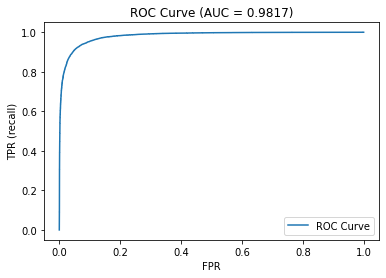

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
score = roc_auc_score(y_true, y_pred)

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title('ROC Curve (AUC = {:.4f})'.format(score))
plt.legend(loc=4)
ROC_name = MODEL_NAME + '_ROC.png'
plt.savefig(ROC_name)

# Attention Visualization

## Load trained models and parameters

In [ ]:
# transformer_on_imdb, transformer_on_imdb_history = load_Transformer_model(base_dir+'model_save/' + MODEL_NAME + '.pth')
# transformer_on_imdb.eval()

transformer_on_yelp, transformer_on_yelp_history = load_Transformer_model(base_dir+'model_save/' + MODEL_NAME + '.pth')
transformer_on_yelp.eval()

Transformer(
  (pos_add_word_embedding): PE_add_Embedding(
    (word_embedding): Embedding(20000, 200)
    (pos_embedding): Embedding(501, 200)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (encode_layers): ModuleList(
    (0): EncoderLayer(
      (multihead_attention): MultiHeadAttention(
        (linear_Q): Linear(in_features=200, out_features=60, bias=True)
        (linear_K): Linear(in_features=200, out_features=60, bias=True)
        (linear_V): Linear(in_features=200, out_features=60, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (attn): ScaleDotProductAttention(
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (out_linear): Linear(in_features=60, out_features=200, bias=True)
        (layer_norm): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      )
      (postion_feedforward): PoswiseFeedForward(
        (conv1): Conv1d(200, 512, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(512, 200, kernel_size=(1,), stride=(1,))

## Get the attention layer output by Pytorch hook function

In [ ]:
att_weights = []
def hook_attention(module, input, output):
    
    with torch.no_grad():
        global att_weights
        att_weights.clear()

        att_weights.append(output[0].data.cpu().numpy())
        # att_weights.append(output.data.cpu().numpy())

In [ ]:
try:
    handle.remove()
except:
    pass

# handle = transformer_on_imdb.inter_attn.register_forward_hook(hook_attention)
handle = transformer_on_yelp.inter_attn.register_forward_hook(hook_attention)

## Load data for visualization

In [ ]:
# df_test = pd.read_csv('dataset/IMDB/test.csv')
df_test = pd.read_csv('dataset/Yelp/yelp_test.csv')
df_test.columns = ['label', 'review']
df_test.head()

,label,review
0,1,Last summer I had an appointment to get new ti...
1,2,"Friendly staff, same starbucks fair you get an..."
2,1,The food is good. Unfortunately the service is...
3,2,Even when we didn't have a car Filene's Baseme...
4,2,"Picture Billy Joel's \""Piano Man\"" DOUBLED mix..."


## Predict single example and visualize attention

In [ ]:
def predict_single_example(model, text, zh=False):
    if zh:
        df_words = pd.DataFrame(list(jieba.cut(text)), columns=['raw_word'])
        df_words['clean_word'] = df_words['raw_word']
    else:
        df_words = pd.DataFrame(transform_punc(text).split(), columns=['raw_word'])
        df_words['clean_word'] = df_words['raw_word'].apply(clean_text).str.replace(r'\s+', '')

    df_words['word_id'] = df_words['clean_word'].apply(lambda x: word2num_series.get(x, None))
    num_series = df_words['word_id'].dropna().astype(int)
    X = torch.tensor(list(num_series), dtype=torch.int64).to(DEVICE).unsqueeze(0)
    length = torch.tensor([len(num_series)]).to(DEVICE)
    
    model.eval()
    predict = model(X)
    wts = att_weights[0]
    if wts.shape[1] < len(num_series):
      diff = len(num_series) - wts.shape[1]
      z = np.zeros(diff)
      wts_ = np.concatenate((wts, z), axis=None)
      wts_ = wts_.reshape((1, wts_.shape[0]))
    
    else:
      wts_ = wts[:, :len(num_series)]
    att_series = pd.Series(wts_.squeeze(0), index=num_series.index)
    
    df_words['att_weights'] = att_series
    df_words.fillna(0, inplace=True)
    return F.sigmoid(predict).item(), df_words

# Examples in IMDB dataset

In [ ]:
index = 1023

# predict, attention_df = predict_single_example(transformer_on_imdb, df_test['review'][index], zh=False)
predict, attention_df = predict_single_example(transformer_on_yelp, df_test['review'][index], zh=False)

In [ ]:
import matplotlib
def colorize(words, color_array):
    cmap=matplotlib.cm.Blues
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        # print(color)
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string

In [ ]:
html_filename = MODEL_NAME + '.html'
attention_map = colorize(attention_df['raw_word'], attention_df['att_weights'])
with open(html_filename, 'w') as f:
    f.write(attention_map)